In [98]:
import geodatasets
import geopandas as gpd
import folium
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import datetime
from pathlib import Path

# 1. Exploring Metadata

Loading the Metadata as DataFrame

In [99]:
# current directory
current_dir = os.getcwd()
# parent directory of current directory
parent_dir = os.path.dirname(current_dir)
# relative path to train metadata.csv
relative_path_train = "data/train_data/metadata.csv"
# full path of train metadata.csv
csv_path_train = os.path.join(parent_dir, relative_path_train)

# relative path to test metadata.csv
relative_path_test = "data/test_data/metadata.csv"
# full path of test metadata.csv
csv_path_test = os.path.join(parent_dir, relative_path_test)

meta = pd.read_csv(csv_path_train)
meta_test = pd.read_csv(csv_path_test)

In [100]:
print(meta.head())
print(meta.dtypes)

       date id_coord plume    set        lat         lon  coord_x  coord_y  \
0  20230223  id_6675   yes  train  31.528750   74.330625       24       47   
1  20230103  id_2542   yes  train  35.538000  112.524000       42       37   
2  20230301  id_6546   yes  train  21.060000   84.936667       58       15   
3  20230225  id_6084   yes  train  26.756667   80.973333       28       62   
4  20230105  id_2012   yes  train  34.800000   40.770000       59       44   

                                                path  
0  images/plume/20230223_methane_mixing_ratio_id_...  
1  images/plume/20230103_methane_mixing_ratio_id_...  
2  images/plume/20230301_methane_mixing_ratio_id_...  
3  images/plume/20230225_methane_mixing_ratio_id_...  
4  images/plume/20230105_methane_mixing_ratio_id_...  
date          int64
id_coord     object
plume        object
set          object
lat         float64
lon         float64
coord_x       int64
coord_y       int64
path         object
dtype: object


In [101]:
# convert date column to datetime
meta['date'] = pd.to_datetime(meta['date'], format="%Y%m%d", errors='coerce')
meta_test['date'] = pd.to_datetime(meta_test['date'], format="%Y%m%d", errors='coerce')

In [105]:
summary_stats = meta.describe()
summary_stats_test = meta_test.describe()

print(summary_stats, summary_stats_test)

                                date         lat         lon     coord_x  \
count                            430  430.000000  430.000000  430.000000   
mean   2023-02-13 15:30:58.604651264   29.219819   53.829356   31.448837   
min              2023-01-01 00:00:00  -47.482444 -114.883661    0.000000   
25%              2023-01-21 00:00:00   23.603333   37.203908   18.000000   
50%              2023-02-12 12:00:00   31.528750   61.693333   30.500000   
75%              2023-03-03 18:00:00   36.136960   81.723449   44.000000   
max              2023-04-06 00:00:00   68.570113  128.748371   64.000000   
std                              NaN   15.522465   48.342344   16.800931   

          coord_y  
count  430.000000  
mean    33.002326  
min     -9.000000  
25%     14.000000  
50%     34.500000  
75%     51.000000  
max     77.000000  
std     21.022410                                   date         lat         lon     coord_x  \
count                            109  109.000000  109.00000

In [109]:
meta_test

,date,id_coord,lat,lon,coord_x,coord_y
0,2023-02-13,id_6148,23.437500,90.645000,54,10
1,2023-02-06,id_3348,33.513333,-87.203333,31,55
2,2023-01-21,id_3733,26.424286,80.284286,33,44
3,2023-02-04,id_5491,30.246667,71.483333,59,59
4,2023-01-30,id_4287,23.763333,86.396667,46,46
...,...,...,...,...,...,...
104,2023-01-11,id_5510,32.713854,44.609398,55,54
105,2023-01-22,id_5510,32.713854,44.609398,55,54
106,2023-01-29,id_4690,35.950275,40.267652,29,28
107,2023-04-04,id_5510,32.713854,44.609398,55,54


## Geographic Location of our Images

In [107]:
# creating separate df for plume
plume_data = meta[meta['plume']=="yes"]
# creating separate df for no plume
no_plume_data = meta[meta['plume']!="yes"]

## Static Image of Map

C:\Users\schth\AppData\Local\Temp\ipykernel_59364\873062001.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


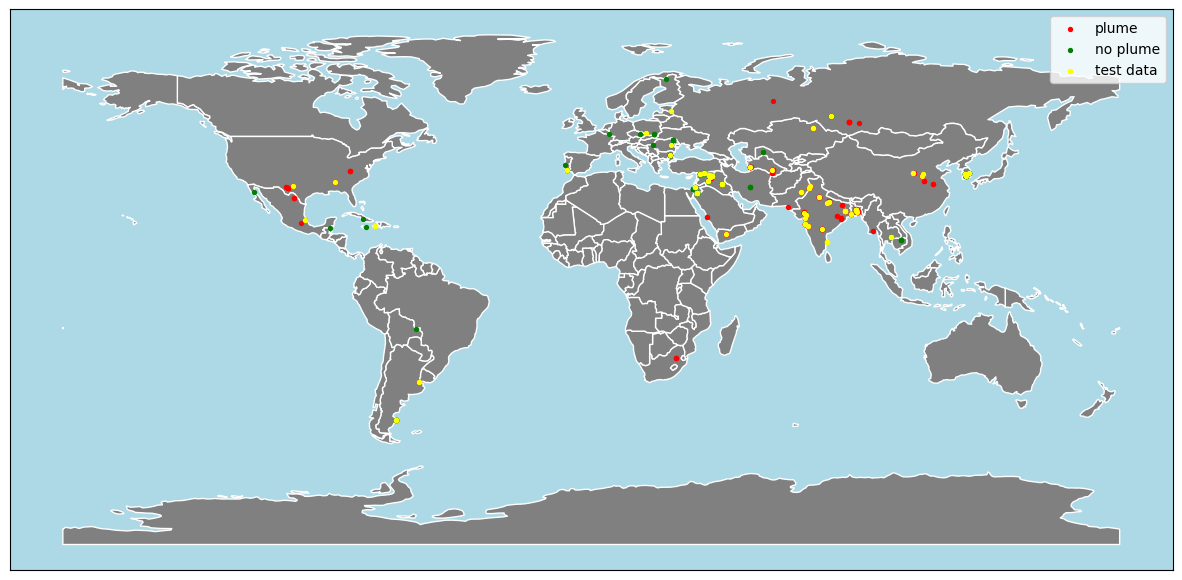

In [111]:
plume = gpd.GeoDataFrame(plume_data[['id_coord','lon','plume', 'lat', 'set', 'coord_x', 'coord_y']],
                       geometry=gpd.points_from_xy(plume_data.lon, plume_data.lat))
no_plume = gpd.GeoDataFrame(no_plume_data[['id_coord','lon','plume', 'lat', 'set', 'coord_x', 'coord_y']],
                       geometry=gpd.points_from_xy(no_plume_data.lon, no_plume_data.lat))

test = gpd.GeoDataFrame(meta_test[['id_coord','lon', 'lat', 'coord_x', 'coord_y']],
                       geometry=gpd.points_from_xy(meta_test.lon, meta_test.lat))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(figsize=(15, 8))
ax.set_facecolor('lightblue')
world.plot(ax=ax, color='grey', edgecolor='white')
plume.plot(ax=ax, color='red', markersize=8, label='plume')
no_plume.plot(ax=ax, color='green', markersize=8, label='no plume')
test.plot(ax=ax, color='yellow', markersize=8, label='test data')

ax.tick_params(left=False,
               right=False,
               top=False,
               bottom=False,
               labelleft=False,
               labeltop=False,
               labelright=False,
               labelbottom=False)

ax.legend()

plt.show()

## Interactive Map

In [112]:
m = world.explore(
    legend=True,
    name="world"
)

plume.explore(
    m=m,
    color="red",
    name="plume"
)

no_plume.explore(
    m=m,
    color="green",
    name="no_plume"
)

test.explore(
    m=m,
    color="yellow",
    name="test"
)

# use folium to add alternative mape
folium.TileLayer("CartoDB positron", show=False).add_to(m)  
# use folium to add layer control
folium.LayerControl().add_to(m)  

m

# 2. Exploring Image Data

In [151]:
def read_tiff(file_path):
    """reads tiff files and returns images

    Args:
        file_path (str): the file path of the image(s)

    Returns:
        image(2D array): returns a 2 or 3d array (in our case 2D)
    """
    image = imageio.imread(file_path)
    return image

In [152]:
class CustomToTensor(object):
    def __call__(self, img):
        return img.astype(np.float32)/65535.0

In [153]:
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor()
# ])

In [154]:
def create_dataframe(directory, label):
    data = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            file_path = os.path.join(directory, filename)
            #reads tifs
            image_data = read_tiff(file_path).astype(np.float32)/65535.0
            #if transform:
                #image_data = transform(image_data)
            # adds each image to data
            data.append(image_data)
            labels.append(label)
    
    df = pd.DataFrame({'image':data, 'label':labels})

    return df

In [155]:
# relative path to train plume images
relative_path_train_p = "data/train_data/images/plume"
# relative path to train no plume images
relative_path_train_np = "data/train_data/images/no_plume"

# full path to train plume images
train_image_p = os.path.join(parent_dir, relative_path_train_p)
# full path to train no-plume images
train_image_np = os.path.join(parent_dir, relative_path_train_np)

In [156]:
df_p = create_dataframe(train_image_p, 1)
df_np = create_dataframe(train_image_np, 0)

C:\Users\schth\AppData\Local\Temp\ipykernel_59364\3004375228.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_path)


In [157]:
# Calculate summary statistics for the 'plume' class
plume_means = [np.mean(img) for img in df_p['image']]
plume_stds = [np.std(img) for img in df_p['image']]
plume_min = [np.min(img) for img in df_p['image']]
plume_max = [np.max(img) for img in df_p['image']]

# Calculate summary statistics for the 'plume' class
no_plume_means = [np.mean(img) for img in df_np['image']]
no_plume_stds = [np.std(img) for img in df_np['image']]
no_plume_min = [np.min(img) for img in df_np['image']]
no_plume_max = [np.max(img) for img in df_np['image']]

# Create plume summary dataframe
plume_summary = pd.DataFrame({'Mean': plume_means,
                              'Std': plume_stds,
                              'Min': plume_min,
                              'Max': plume_max})

# Create no plume summary dataframe
no_plume_summary = pd.DataFrame({'Mean': no_plume_means,
                              'Std': no_plume_stds,
                              'Min': no_plume_min,
                              'Max': no_plume_max})

print("Summary Statistics for 'Plume' Class:")
print(plume_summary.describe())

print("\nSummary Statistics for 'No Plume' Class:")
print(no_plume_summary.describe())

Summary Statistics for 'Plume' Class:
             Mean         Std    Min    Max
count  214.000000  214.000000  214.0  214.0
mean     0.208485    0.188132    0.0    1.0
std      0.060554    0.041639    0.0    0.0
min      0.087128    0.083593    0.0    1.0
25%      0.167610    0.157387    0.0    1.0
50%      0.202049    0.185096    0.0    1.0
75%      0.241920    0.213282    0.0    1.0
max      0.481151    0.345536    0.0    1.0

Summary Statistics for 'No Plume' Class:
             Mean         Std    Min         Max
count  214.000000  214.000000  214.0  214.000000
mean     0.254434    0.235685    0.0    0.999801
std      0.061153    0.041784    0.0    0.002052
min      0.077032    0.098116    0.0    0.978729
25%      0.214842    0.208550    0.0    1.000000
50%      0.247729    0.235637    0.0    1.000000
75%      0.290312    0.259745    0.0    1.000000
max      0.447734    0.384007    0.0    1.000000


In [171]:
df_p['image'][0].dtype

dtype('float32')

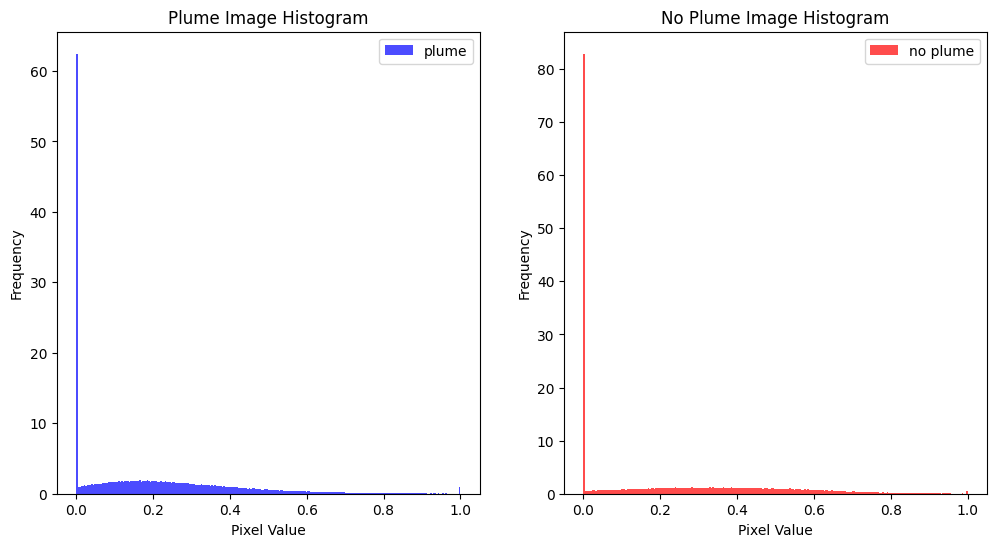

In [177]:
plume_images = np.concatenate(df_p['image'].values)
no_plume_images = np.concatenate(df_np['image'].values)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(plume_images.ravel(),
         bins=256,
         range=(0.0, 1.0),
         density=True,
         color='blue',
         alpha=0.7,
         label='plume')
plt.title('Plume Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()


plt.subplot(1, 2, 2)
plt.hist(no_plume_images.ravel(),
         bins=256,
         range=(0.0, 1.0),
         density=True,
         color='red',
         alpha=0.7,
         label='no plume')
plt.title('No Plume Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.legend()
plt.show()


In [158]:
# concats both dfs
merged_train_df = pd.concat([df_p, df_np], ignore_index=True)

shuffled_train_df = merged_train_df.sample(frac=1,
                                           random_state=42).reset_index(drop=True)

In [159]:
shuffled_train_df

,image,label
0,"[[0.0, 0.0, 0.0, 0.16304265, 0.16304265, 0.206...",0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,"[[0.0, 0.0, 0.0, 0.0, 0.18381017, 0.18381017, ...",1
3,"[[0.23985657, 0.23985657, 0.25090408, 0.250904...",1
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
...,...,...
423,"[[0.18600747, 0.20251773, 0.20251773, 0.090547...",1
424,"[[0.24530403, 0.24530403, 0.2559701, 0.2624246...",1
425,"[[0.1484245, 0.1484245, 0.071564816, 0.0, 0.0,...",0
426,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7723049...",0
